Amplicon data of two different marker genes from the same samples
========

### Testing functionality with RAPIDS

#### Import all the dependencies

In [2]:
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # is this necessary with cuml?
import seaborn as sns # will this work with RAPIDS?

# RAPIDS libraries
import cudf # RAPIDS equivalent of pandas
import cupy as cp # RAPIDS equivalent of numpy
from cuml.decomposition import PCA # RAPIDS equivalent of scikit-learn

In [ ]:
# Check hardware configuration
!nvidia-smi

In [113]:
# Test for cuda device
torch.cuda.get_device_name(0)

'Quadro T2000'

#### Move to working directory

In [5]:
# Need to upload our data to the cluster and provide cluster path
os.chdir("/Users/nastassia.patin/GitHub/MarineDNA/Data")

## 01. This section imports the amplicon data sets as raw counts and calls an model the ASV occurrences as probability distributions. 

#### Import amplicon data sheets as pandas dataframes and take a look

In [ ]:
file1 = "Flyer2018_16S_table_counts.tsv"
file2 = "Flyer2018_18S_table_counts.tsv"
asvs1 = cudf.read_csv(file1, index_col=0, sep="\t")
asvs2 = cudf.read_csv(file2, index_col=0, sep="\t")

### Function to model the ASV count distributions

In [ ]:
def ranRelPct_df(df):
    def betaRow(row):
      ran_row = cp.random.beta(row + 1, row.sum() - row + 1)
      return ran_row
    return df.apply(lambda x: betaRow(x), axis = 1, result_type='expand') 

#### Run the function in a loop over both amplicon data sets and make a list of the two data frames

In [ ]:
asvs_list = []

for file in [file1, file2]:
    asvs = cudf.read_csv(file, index_col=0, sep='\t')
    asvs_modeled = ranRelPct_df(asvs)
    asvs_list.append(asvs_modeled)

In [ ]:
# We lose sample names in this operation
asvs_list

#### Separate the two data frames into the 16S and 18S modeled ASV counts and transpose for PCA

In [ ]:
df_16S = asvs_list[0].T
df_18S = asvs_list[1].T

## 02. Reduce dimensionality and visualize principal components

In [18]:
# Untransformed 16S
pca = PCA(n_components=62)
pca.fit_transform(df_16S)
exp_var = pca.explained_variance_ratio_
variance_array_16S = cp.cumsum(exp_var * 100)

In [19]:
# Untransformed 18S
pca = PCA(n_components=62)
pca.fit_transform(df_18S)
exp_var = pca.explained_variance_ratio_
variance_array_18S = cp.cumsum(exp_var * 100)

### Plot components vs variance explained

#### Function to format variance numpy array for seaborn plot

In [22]:
def format_variance_data_for_plotting(variance_array):
    df = cudf.DataFrame(variance_array, columns = ["Explained variance"])
    df = df.reset_index(level=0)
    df['index'] = df['index'] + 1
    df = df.rename(columns = {"index" : "Component number"})
    return(df)

#### Apply function to raw count probabilities

[Text(0.5, 1.0, 'Principal components of ASV count probabilities')]

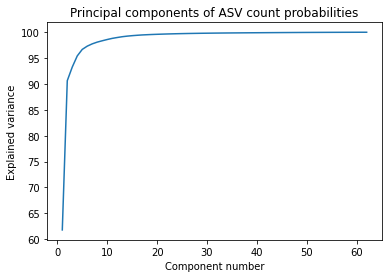

In [23]:
# 16S count data
df_variance = format_variance_data_for_plotting(variance_array_16S)
sns.lineplot(data=df_variance, x="Component number", 
             y="Explained variance").set(title='Principal components of ASV count probabilities') 

[Text(0.5, 1.0, 'Principal components of ASV count probabilities')]

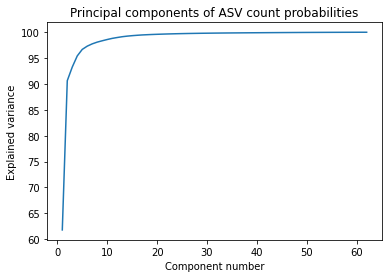

In [24]:
# 18S count data
df_variance = format_variance_data_for_plotting(variance_array_16S)
sns.lineplot(data=df_variance, x="Component number", 
             y="Explained variance").set(title='Principal components of ASV count probabilities') 

### Plot principal components of raw ASV count probabilities

[Text(0.5, 1.0, '16S PCA, raw count probabilities')]

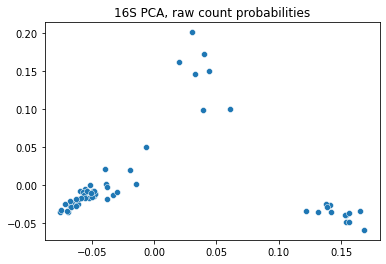

In [25]:
pca_16 = PCA(n_components=3)
pcs_16 = pca.fit_transform(df_16S) 

pc1_values_16 = pcs_16[:,0]
pc2_values_16 = pcs_16[:,1]
sns.scatterplot(x=pc1_values_16, y=pc2_values_16).set(title="16S PCA, raw count probabilities")

[Text(0.5, 1.0, '18S PCA, raw count probabilities')]

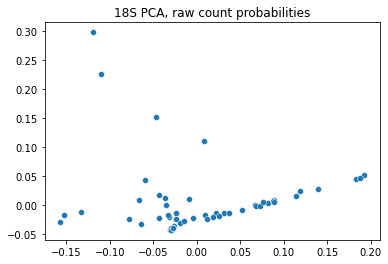

In [26]:
pca_118 = PCA(n_components=3)
pcs_18 = pca.fit_transform(df_18S)

pc1_values_18 = pcs_18[:,0]
pc2_values_18 = pcs_18[:,1]
sns.scatterplot(x=pc1_values_18, y=pc2_values_18).set(title="18S PCA, raw count probabilities")